# Libraries

In [12]:
## Standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
import copy
import argparse
import torch
import gc
import sys
from pathlib import Path
from tqdm import tqdm

# path to the directory that CONTAINS the package folder
project_root = Path("/home/benedetti/PL")   # adjust to your real path

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PL.model.model import TwoBodiesModel
from PL.dataset.random_features import RandomDatasetPowerLaw, GeneralDataset
from PL.utils.saving import init_training_h5, save_training, load_training
from PL.utils.functions import start_overlap, compute_asymmetry, overlap, basins_of_attraction_inp_vectors

from PL.training.training_RF import train_model, initialize

device = torch.device("cuda:0")

data_PATH = "./data"


# Parameters

In [2]:
# Nature of variables and loss
d=1
spin_type = "vector"

pick_biased = True

# Step
n = 100

L=3
eta=2.
alpha_P = 10.
alpha_D = 0.1

N = 1000
P = int(alpha_P*N)
D = int(alpha_D*N)
d = 1
seed = 100


dataset = RandomDatasetPowerLaw(P, N, D, d, eta=eta, L=L, seed=seed, spin_type=spin_type, coefficients="binary", shift=0, pick_biased=pick_biased)
model  = TwoBodiesModel(N, d, spin_type=spin_type, device=device)
xi = dataset.xi.to(device)
f =  dataset.f.to(device)
model.Hebb(xi, "Tensorial")
x = f.clone()
for i_n in range(n):
    x = model.dyn_step(x)
overlap_k = torch.abs(torch.einsum("kia,kia->k", f, x))/N

print(overlap_k[:100])

def count_overlaps_above_threshold(overlaps, thr):
    count = 0
    for overlap in overlaps:
        if overlap > thr:
            count += 1
        else:
            break  # Stop at the first overlap that is lower than the threshold
    return count

num_stable_f = count_overlaps_above_threshold(overlap_k, 0.99)

print(num_stable_f)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0520, 0.0280,
        0.0520, 0.0340, 0.0420, 0.0200, 0.0480, 0.0240, 0.0600, 0.0500, 0.0300,
        0.0160, 0.0440, 0.0380, 0.0440, 0.0380, 0.0200, 0.0340, 0.0540, 0.0420,
        0.0260, 0.0640, 0.0240, 0.0240, 0.0240, 0.0260, 0.0480, 0.0260, 0.0900,
        0.0500, 0.0180, 0.0300, 0.0220, 0.0740, 0.0440, 0.0380, 0.1280, 0.0780,
        0.0360, 0.0880, 0.0080, 0.0500, 0.0380, 0.0060, 0.0840, 0.0120, 0.0860,
        0.0500, 0.0140, 0.0300, 0.0320, 0.0600, 0.0920, 0.0720, 0.0300, 0.0460,
        0.0180, 0.0580, 0.0140, 0.0400, 0.0180, 0.0140, 0.0220, 0.0280, 0.0160,
        0.0360, 0.0420, 0.0160, 0.0080, 0.0480, 0.0420, 0.0220, 0.0460, 0.0360,
        0.0300, 0.0600, 0.0960, 0.0200, 0.0520, 0.0080, 0.1140, 0.0300, 0.0260,
        0.0140, 0.0840, 0.0740, 0.0300, 0.0180, 0.0420, 0.0560, 0.0540, 0.0600,
        0.0200], device='cuda:1')
7


In [3]:
P_hat = 20

stable_features = torch.arange(0, num_stable_f)
unstable_features = torch.arange(num_stable_f, D)

stable_xi = dataset.get_generalization_selected_features(P_hat, stable_features, L=L)
unstable_xi = dataset.get_generalization_selected_features(P_hat, unstable_features, L=L)

stable_xi = stable_xi.to(device)
unstable_xi = unstable_xi.to(device)

x = stable_xi.clone()

for i_n in range(n):
    x = model.dyn_step(x)

overlap_stable = torch.abs(torch.einsum("kia,kia->k", stable_xi, x))/N
overlap_stable_f = torch.abs(torch.einsum("kia,gia->kg", dataset.f.to(device), x))/N

print("Stable:", overlap_stable)
print("F Stable:", overlap_stable_f)

x = unstable_xi.clone()

for i_n in range(n):
    x = model.dyn_step(x)

overlap_unstable = torch.abs(torch.einsum("kia,kia->k", unstable_xi, x))/N

print("Unstable:", overlap_unstable)

Stable: tensor([0.5520, 0.5200, 0.4820, 0.4840, 0.5040, 0.5140, 0.0460, 0.5080, 0.5060,
        0.5200, 0.5180, 0.5100, 0.5040, 0.4760, 0.5040, 0.4720, 0.4880, 0.4780,
        0.4780, 0.5100], device='cuda:1')
F Stable: tensor([[0.0140, 1.0000, 1.0000,  ..., 0.0140, 1.0000, 0.0100],
        [0.0320, 0.0100, 0.0100,  ..., 0.0320, 0.0100, 1.0000],
        [1.0000, 0.0140, 0.0140,  ..., 1.0000, 0.0140, 0.0320],
        ...,
        [0.0340, 0.0160, 0.0160,  ..., 0.0340, 0.0160, 0.0540],
        [0.0060, 0.0600, 0.0600,  ..., 0.0060, 0.0600, 0.0180],
        [0.0140, 0.0200, 0.0200,  ..., 0.0140, 0.0200, 0.0220]],
       device='cuda:1')
Unstable: tensor([0.0040, 0.0200, 0.0520, 0.0480, 0.0380, 0.0120, 0.0180, 0.0440, 0.0120,
        0.0280, 0.0180, 0.0200, 0.0440, 0.0840, 0.1040, 0.0340, 0.0080, 0.0300,
        0.0620, 0.0520], device='cuda:1')


# PL

## One training

In [ ]:
# Model and training
l=1.
lr = 0.1*N

epochs=10000
valid_every = 2
max_grad = 20.
init_overlap = 1.
n=100

loss_type = "CE"
l2 = False
alpha=1.

In [15]:
model_PL  = TwoBodiesModel(N, d, spin_type=spin_type, device=device)

optimizer = torch.optim.SGD(model_PL.parameters(), lr=lr)

xi = dataset.xi.to(device)
f =  dataset.f.to(device)
#model_PL.Hebb(xi, "Tensorial")

P_hat = 100

dataset_f = GeneralDataset(D, dataset.f)
xi_generalization = dataset.get_generalization(P_hat, L=L)
dataset_generalization = GeneralDataset(P_hat, xi_generalization)
batch_size = P
batch_size_f = D

model2 = TwoBodiesModel(N, d, spin_type=spin_type, device=device)
model2.to(device)
model2.Hebb(dataset.xi.to(device), 'Tensorial')  # Applying the Hebb rule
J2 = model2.J.squeeze().cpu().detach().numpy()
norm_J2 = np.linalg.norm(J2)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
dataloader_f = torch.utils.data.DataLoader(dataset_f, batch_size=batch_size_f, shuffle=False, drop_last=False, num_workers=2)
dataloader_generalization = torch.utils.data.DataLoader(dataset_generalization, batch_size=P_hat, shuffle=False, drop_last=False, num_workers=2)

epochs_to_save = [10,50,200]
save = True
print("epochs:{}  lr:{}  max_norm:{}  init_overlap:{}  n:{}  l:{}".format(epochs, lr, max_grad, init_overlap, n, l))


epochs:10000  lr:100.0  max_norm:20.0  init_overlap:1.0  n:100  l:1.0


In [16]:
model_name_base = "PL_{}_{}_GD_PW_eta{}_N_{}_P_{}_D{}_l_{}_epochs{}_lr{}_l2{}".format(spin_type, loss_type, eta, N, P, D, l, epochs, lr, l2)
model_name = model_name_base + ".pth"
print(model_name)

PL_vector_CE_GD_PW_eta2.0_N_4000_P_40000_D400_l_1.0_epochs10000_lr100.0_l2False.pth


In [17]:
train_model(
    model_PL, dataloader, dataloader_f, dataloader_generalization, epochs, 
    lr, max_grad, device, data_PATH, init_overlap, 
    n, l, optimizer, J2, norm_J2, valid_every, epochs_to_save, model_name_base, save, l2, alpha,loss_type
)

# epoch lambda train_loss learning_rate train_metric features_metric generalization_metric // // // norm_x


100 0.5753056406974792 0.015420211479067802 100.0 0.9735081 0.21120441 0.9614801 0.9911869 0.46301582 0.98037004 12649.1103515625
200 0.6233677268028259 0.009490774013102055 100.0 0.98328125 0.24035066 0.9662651 0.99598116 0.5628047 0.98706007 12649.1103515625
300 0.6683117151260376 0.007116770837455988 100.0 0.9873645 0.27089942 0.96627015 0.99768007 0.6149022 0.9900951 12649.1103515625
400 0.7081565856933594 0.0057362401857972145 100.0 0.9898301 0.29536688 0.9711601 0.9985752 0.64749724 0.99218017 12649.1103515625
500 0.743388831615448 0.004809495992958546 100.0 0.9917001 0.3155619 0.97118014 0.9991062 0.6697722 0.99329513 12649.1103515625


KeyboardInterrupt: 

In [9]:
x = f.clone()
for i_n in range(n):
    x = model_PL.dyn_step(x)
overlap_k = torch.abs(torch.einsum("kia,kia->k", f, x))/N

print(overlap_k[:100])

def count_overlaps_above_threshold(overlaps, thr):
    count = 0
    for overlap in overlaps:
        if overlap > thr:
            count += 1
        else:
            break  # Stop at the first overlap that is lower than the threshold
    return count

num_stable_f = count_overlaps_above_threshold(overlap_k, 0.99)

print(num_stable_f)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0240, 0.9980, 0.9980, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9940, 1.0000, 0.0000, 1.0000,
        0.0520, 0.0780, 0.0000, 0.0400, 1.0000, 0.0140, 0.9960, 1.0000, 0.0760,
        0.9980, 0.0040, 1.0000, 0.0340, 1.0000, 0.0420, 0.9860, 0.0220, 0.0360,
        0.0780, 0.0680, 0.0960, 1.0000, 0.9980, 0.0300, 0.9960, 0.0060, 0.0400,
        0.0360, 0.0840, 0.0740, 0.9860, 0.0120, 0.0600, 0.0620, 0.0400, 0.0280,
        0.0840], device='cuda:1')
48


In [10]:
P_hat = 20

num_stable_f = 10

stable_features = torch.arange(0, num_stable_f)
unstable_features = torch.arange(num_stable_f, D)

stable_xi = dataset.get_generalization_selected_features(P_hat, stable_features, L=L)
unstable_xi = dataset.get_generalization_selected_features(P_hat, unstable_features, L=L)

stable_xi = stable_xi.to(device)
unstable_xi = unstable_xi.to(device)

x = stable_xi.clone()

for i_n in range(n):
    x = model_PL.dyn_step(x)

overlap_stable = torch.abs(torch.einsum("kia,kia->k", stable_xi, x))/N
overlap_stable_f = torch.abs(torch.einsum("kia,gia->kg", dataset.f.to(device), x))/N

print("Stable:", overlap_stable)
print("F Stable:", overlap_stable_f[:,0])

x = unstable_xi.clone()

for i_n in range(n):
    x = model_PL.dyn_step(x)

overlap_unstable = torch.abs(torch.einsum("kia,kia->k", unstable_xi, x))/N
overlap_unstable_f = torch.abs(torch.einsum("kia,gia->kg", dataset.f.to(device), x))/N

print("Unstable:", overlap_unstable)
print("F Unstable:", overlap_unstable_f[:,1])

Stable: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:1')
F Stable: tensor([0.0300, 0.0520, 0.0160, 0.4600, 0.0460, 0.4740, 0.5580, 0.0140, 0.0380,
        0.0120, 0.0140, 0.0000, 0.0100, 0.0280, 0.0020, 0.0160, 0.0020, 0.0200,
        0.0260, 0.0500, 0.0380, 0.0520, 0.0300, 0.0260, 0.0380, 0.0600, 0.0240,
        0.0200, 0.0380, 0.0620, 0.0080, 0.0300, 0.0280, 0.0100, 0.0440, 0.0420,
        0.0520, 0.0360, 0.0240, 0.0680, 0.0020, 0.0220, 0.0120, 0.0240, 0.0040,
        0.0120, 0.0540, 0.0180, 0.0220, 0.0520, 0.0200, 0.0100, 0.0380, 0.0040,
        0.0220, 0.0720, 0.0040, 0.0740, 0.0360, 0.0320, 0.0020, 0.0320, 0.0160,
        0.0500, 0.0080, 0.0740, 0.0080, 0.0160, 0.0840, 0.0720, 0.0300, 0.0420,
        0.0620, 0.0180, 0.0100, 0.0060, 0.0020, 0.0200, 0.0520, 0.0440, 0.0140,
        0.0480, 0.0360, 0.0940, 0.0120, 0.0160, 0.0020, 0.0300, 0.0080, 0.0680,
        0.0160, 0.0140, 0.0040, 0.0740, 0.0120, 0.0000, 0.0020, 0.02

In [11]:
P_hat = 20

xi_gen = dataset.get_generalization(P_hat, L=L)

xi_gen = xi_gen.to(device)

x = xi_gen.clone()

for i_n in range(n):
    x = model_PL.dyn_step(x)

overlap_stable = torch.abs(torch.einsum("kia,kia->k", xi_gen, x))/N
overlap_stable_f = torch.abs(torch.einsum("kia,gia->kg", dataset.f.to(device), x))/N

print("Stable:", overlap_stable)
print("F Stable:", overlap_stable_f[:,2])

Stable: tensor([1.0000, 1.0000, 0.4980,  ..., 1.0000, 1.0000, 1.0000], device='cuda:1')
F Stable: tensor([1.0000, 0.0100, 0.0140, 0.0060, 0.0320, 0.0280, 0.0320, 0.0520, 0.0280,
        0.0140, 0.0040, 0.0420, 0.0200, 0.0220, 0.0240, 0.0180, 0.0080, 0.0300,
        0.0160, 0.0440, 0.0160, 0.0060, 0.0080, 0.0200, 0.0080, 0.0540, 0.0420,
        0.0260, 0.0640, 0.0240, 0.0020, 0.0240, 0.0260, 0.0480, 0.0260, 0.0160,
        0.0500, 0.0180, 0.0300, 0.0220, 0.0080, 0.0440, 0.0380, 0.0260, 0.0020,
        0.0020, 0.0880, 0.0080, 0.0240, 0.0380, 0.0060, 0.0200, 0.0120, 0.0860,
        0.0040, 0.0140, 0.0300, 0.0320, 0.0020, 0.0460, 0.0720, 0.0300, 0.0220,
        0.0040, 0.0580, 0.0000, 0.0140, 0.0180, 0.0140, 0.0220, 0.0280, 0.0160,
        0.0360, 0.0120, 0.0160, 0.0080, 0.0160, 0.0420, 0.0220, 0.0180, 0.0360,
        0.0300, 0.0300, 0.0960, 0.0020, 0.0020, 0.0080, 0.0160, 0.0300, 0.0260,
        0.0140, 0.0840, 0.0740, 0.0040, 0.0180, 0.0420, 0.0560, 0.0160, 0.0600,
        0.0200], devic

## Many trainings

In [13]:
# Step
n = 100
d=1
L=3
eta=0.75
alpha_D = 0.5

In [14]:
# Model and training
l=1.

epochs=100
valid_every = 100
max_grad = 20.
init_overlap = 1.
n=100

#training
loss_type = "CE"
l2 = False
alpha=1.
spin_type = "vector"
pick_biased = True
epochs_to_save = [10000]
save = False

In [15]:
def GAP_compute_overlap_array_model(model, dataset, N, P_hat):

    xi = dataset.xi.to(device)

    x = xi.clone()

    for i_n in range(n):
        x = model.dyn_step(x)

    overlap_train = torch.abs(torch.einsum("kia,kia->k", xi, x))/N

    xi_gen = dataset.get_generalization(P_hat).to(device)

    x = xi_gen.clone()

    for i_n in range(n):
        x = model.dyn_step(x)

    overlap_test = torch.abs(torch.einsum("kia,kia->k", xi_gen, x))/N

    return [overlap_train.cpu().numpy(), overlap_test.cpu().numpy()]



In [16]:
def train_single_model(N, P, D):
    lr = 0.05*N

    optimizer = torch.optim.SGD(model_PL.parameters(), lr=lr)
    
    P_hat = 10
    
    dataset_f = GeneralDataset(D, dataset.f)
    xi_generalization = dataset.get_generalization(P_hat, L=L)
    dataset_generalization = GeneralDataset(P_hat, xi_generalization)
    batch_size = P
    batch_size_f = D
    
    model2 = TwoBodiesModel(N, d, spin_type=spin_type, device=device)
    model2.to(device)
    model2.Hebb(dataset.xi.to(device), 'Tensorial')  # Applying the Hebb rule
    J2 = model2.J.squeeze().cpu().detach().numpy()
    norm_J2 = np.linalg.norm(J2)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
    dataloader_f = torch.utils.data.DataLoader(dataset_f, batch_size=batch_size_f, shuffle=False, drop_last=False, num_workers=2)
    dataloader_generalization = torch.utils.data.DataLoader(dataset_generalization, batch_size=P_hat, shuffle=False, drop_last=False, num_workers=2)

    train_model(
        model_PL, dataloader, dataloader_f, dataloader_generalization, epochs, 
        lr, max_grad, device, data_PATH, init_overlap, 
        n, l, optimizer, J2, norm_J2, valid_every, epochs_to_save, model_name_base, save, l2, alpha,loss_type, verbose=False
    )

    cuda_cleanup(dataset_f, dataset_generalization,
     dataloader, dataloader_f, dataloader_generalization,
     optimizer)
    
def cuda_cleanup(*objs):
    for o in objs:
        try:
            del o
        except Exception:
            pass
    gc.collect()
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

# Bias varying $\alpha_P$

In [20]:
P_hat = 1000

N = 2000

#alpha_P_arr = np.array([0.01,0.0316,0.1,0.316,1.,3.16,10.,31.6])

alpha_P_arr = np.array([0.01778, 0.05623, 0.1778, 0.5623, 1.778, 5.623, 17.78
])

seeds_arr = np.arange(1000, 1005)

to_save = np.empty((len(alpha_P_arr), len(seeds_arr)), dtype=object)


for i_s, seed in tqdm(enumerate(seeds_arr)):
    for i_a, alpha_P in enumerate(alpha_P_arr):
        P = int(alpha_P*N)
        D = int(alpha_D*N)
        
        dataset = RandomDatasetPowerLaw(P, N, D, d, eta=eta, L=L, seed=seed, spin_type=spin_type, coefficients="binary", shift=0, pick_biased=pick_biased)
        model_PL  = TwoBodiesModel(N, d, spin_type=spin_type, device=device)

        model_name_base = "."
        
        train_single_model(N, P, D)
        
        to_save[i_a, i_s] = GAP_compute_overlap_array_model(model_PL, dataset, N, P_hat) 

        cuda_cleanup(model_PL)

5it [19:13, 230.65s/it]


In [21]:
means_train = np.empty(len(alpha_P_arr), dtype=object)
std_train = np.empty(len(alpha_P_arr), dtype=object)
means_test = np.empty(len(alpha_P_arr), dtype=object)
std_test = np.empty(len(alpha_P_arr), dtype=object)

for i_a, alpha_P in enumerate(alpha_P_arr):
    D = int(alpha_D*N)
    P = int(alpha_P*N)
    arr_train = np.zeros((len(seeds_arr), P))
    for i_s in range(len(seeds_arr)):
        arr_train[i_s] = to_save[i_a, i_s][0]
    means_train[i_a] = arr_train.mean(axis=0)
    std_train[i_a] = arr_train.std(axis=0)
    arr_test = np.zeros((len(seeds_arr), P_hat))
    for i_s in range(len(seeds_arr)):
        arr_test[i_s] = to_save[i_a, i_s][1]
    means_test[i_a] = arr_test.mean(axis=0)
    std_test[i_a] = arr_test.std(axis=0)

fname = "GAP_PL_curves_eta{}_N{}_alpha_D{}_L{}_epochs{}_varying_alpha_P_mid".format(eta, N, alpha_D,L,epochs)

final_dict = {
    "means_train": means_train,
    "std_train": std_train,
    "means_test": means_test,
    "std_test": std_test,
    "N": N,
    "alpha_D": alpha_D,
    "alpha_P_arr": alpha_P_arr,
    "seeds_arr": seeds_arr,
    "eta": eta
}

np.savez("/home/benedetti/RF_power_law/data/"+fname, **final_dict )

# Results

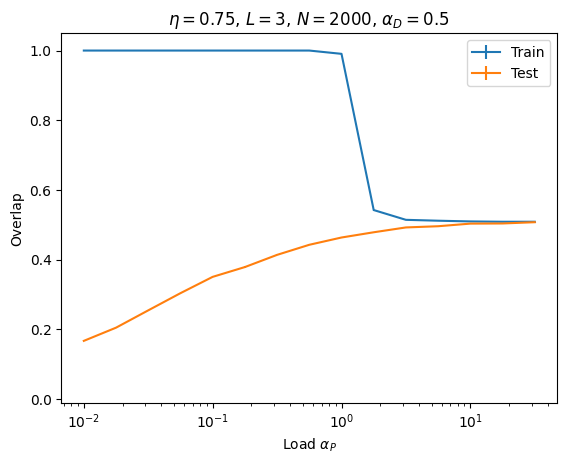

In [40]:
fname = "GAP_PL_curves_eta{}_N{}_alpha_D{}_L{}_epochs{}_varying_alpha_P.npz".format(eta, N, alpha_D, L,epochs)
saved_dict = np.load("/home/benedetti/RF_power_law/data/"+fname, allow_pickle=True)

mean_arr_train = saved_dict["means_train"]
std_arr_train = saved_dict["std_train"]
mean_arr_test = saved_dict["means_test"]
std_arr_test = saved_dict["std_test"]
alpha_P_array = saved_dict["alpha_P_arr"]
aD =  saved_dict["alpha_D"]
N =  saved_dict["N"]
eta_value = saved_dict["eta"]
s_arr = saved_dict["seeds_arr"]

fname = "GAP_PL_curves_eta{}_N{}_alpha_D{}_L{}_epochs{}_varying_alpha_P_mid.npz".format(eta, N, alpha_D, L,epochs)
saved_dict_mid = np.load("/home/benedetti/RF_power_law/data/"+fname, allow_pickle=True)

mean_arr_train_mid = saved_dict_mid["means_train"]
std_arr_train_mid = saved_dict_mid["std_train"]
mean_arr_test_mid = saved_dict_mid["means_test"]
std_arr_test_mid = saved_dict_mid["std_test"]
alpha_P_array_mid = saved_dict_mid["alpha_P_arr"]
aD_mid =  saved_dict_mid["alpha_D"]
N_mid =  saved_dict_mid["N"]
eta_value_mid = saved_dict_mid["eta"]
s_arr_mid = saved_dict_mid["seeds_arr"]

alpha_tot = np.sort(np.concatenate((alpha_P_array, alpha_P_array_mid), axis=0))


train = np.zeros(len(alpha_P_array)+len(alpha_P_array_mid))
std_train = np.zeros(len(alpha_P_array)+len(alpha_P_array_mid))
test = np.zeros(len(alpha_P_array)+len(alpha_P_array_mid))
std_test = np.zeros(len(alpha_P_array)+len(alpha_P_array_mid))

for i_a, alpha_P in enumerate(alpha_P_array):
    i = 2*i_a
    train[i] = mean_arr_train[i_a].mean()
    std_train[i] = std_arr_train[i_a].mean()/math.sqrt(float(len(std_arr_train[i_a])))
    test[i] = mean_arr_test[i_a].mean()
    std_test[i] = std_arr_test[i_a].mean()/math.sqrt(float(len(std_arr_test[i_a])))
    i = i+1
    if i_a < len(alpha_P_array)-1:
        train[i] = mean_arr_train_mid[i_a].mean()
        std_train[i] = std_arr_train_mid[i_a].mean()/math.sqrt(float(len(std_arr_train[i_a])))
        test[i] = mean_arr_test_mid[i_a].mean()
        std_test[i] = std_arr_test_mid[i_a].mean()/math.sqrt(float(len(std_arr_test[i_a])))

plt.errorbar(alpha_tot, train, std_train/math.sqrt(float(len(s_arr))), label="Train")
plt.errorbar(alpha_tot, test, std_test/math.sqrt(float(len(s_arr))), label="Test")

plt.xlabel(r"Load $\alpha_P$")
plt.ylabel("Overlap")
plt.title(rf"$\eta={eta}$, $L={L}$, $N={N}$, $\alpha_D={alpha_D}$")
plt.ylim((-0.01,1.05))
plt.xscale("log")
plt.legend()
plt.show()